In [1]:
%matplotlib inline

In [2]:
# install dependencies: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.7.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from cv2 import imshow as cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
DATA_PATH='/home/appuser/data'
AERIAL_PHOTOS=DATA_PATH +'/aerial'
SAMPLE_PHOTO=AERIAL_PHOTOS +'/_20210209191702.png'
im = cv2.imread(SAMPLE_PHOTO)

#show image using matplotlib 
img = mpimg.imread(SAMPLE_PHOTO)
print(img)

#show image
cv2_imshow('', im)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


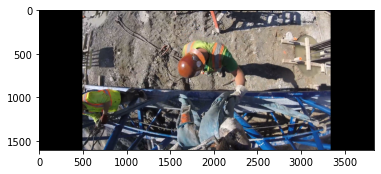

In [6]:
imgplot = plt.imshow(img)

In [7]:
#set up config
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

#initalize predictor w config
predictor = DefaultPredictor(cfg)

outputs = predictor(im)

/tmp is not accessible! Using /var/tmp/iopath_cache instead!
model_final_280758.pkl: 167MB [00:11, 14.7MB/s]                           
/home/appuser/detectron2/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


In [8]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0, 0, 8], device='cuda:0')
Boxes(tensor([[ 490.9374,  906.3814,  966.2369, 1368.8262],
        [1605.0171,  318.3258, 2383.7158, 1307.1853],
        [ 473.6706,  850.6656, 3382.3513, 1558.6760]], device='cuda:0'))


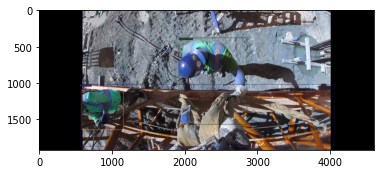

In [9]:
# use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
detections = out.get_image()[:, :, ::-1]
plt.imshow(detections)

In [10]:
#download, decompress the data
#!wget https://github.com/lsalg/fallshadow-detection/data/aerial.zip
#!unzip aerial_dataset.zip > /dev/null
#!curl -L "https://app.roboflow.com/ds/Hb78plHJpG?key=imKqxMIHtr" > roboflow.zip
!curl -L "https://app.roboflow.com/ds/Hb78plHJpG?key=imKqxMIHtr" > roboflow.zip
!unzip roboflow.zip > /dev/null
!rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1511      0 --:--:-- --:--:-- --:--:--  1511
100 12.0M  100 12.0M    0     0  11.5M      0  0:00:01  0:00:01 --:--:-- 45.8M


In [11]:
#train on custom dataset (crane/person)
#dataset is in COCO format, following four lines will train and valuate the dataset:
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances

register_coco_instances("fallshadow_train", {}, "./train/_annotations.coco.json", "./train")
register_coco_instances("fallshadow_val", {}, "./valid/_annotations.coco.json", "./valid")


In [12]:
#after registers the data
train_data = DatasetCatalog.get("fallshadow_train")
val_data = DatasetCatalog.get("fallshadow_val")

WARNING [05/05 03:43:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 03:43:08 d2.data.datasets.coco]: Loaded 309 images in COCO format from ./train/_annotations.coco.json
WARNING [05/05 03:43:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 03:43:08 d2.data.datasets.coco]: Loaded 26 images in COCO format from ./valid/_annotations.coco.json


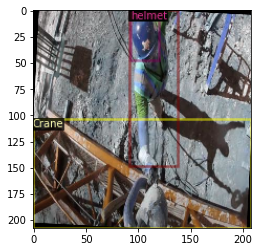

In [15]:
#verify the data loading is correct randomly from the training set
#dataset_dicts = get_crane_dicts("fallshadow_train")
train_metadata = MetadataCatalog.get("fallshadow_train")
val_metadata = MetadataCatalog.get("fallshadow_val")

for d in random.sample(train_data, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    #cv2_imshow()
    plt.imshow(out.get_image()[:, :, ::-1])


In [16]:
#TRAIN!
#takes roughly ~6 minutes to train 300 iterations
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fallshadow_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00020  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  #see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/05 03:43:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [17]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir cfg.OUTPUT_DIR


In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`